# EEG Data Reading and Processing with MNE-Python

In [1]:
import mne
import warnings
import numpy as np
import matplotlib.pyplot as plt

from almirah import Layout

mne.set_log_level(False)
warnings.filterwarnings('ignore')

In [2]:
lay = Layout(root="/path/to/data", specification_name="bids")
lay

<Layout root: '/path/to/data'>

In [2]:
lay = Layout.get(specification_name='bids')

In [3]:
files = lay.query(datatype="eeg", extension=".vhdr")
len(files)

2223

In [4]:
vhdr_file = lay.query(subject="D0019", session="101", datatype="eeg", task="rest", extension =".vhdr")[0]
eeg_file = lay.query(subject="D0019", session="101", datatype="eeg", task="rest", extension=".eeg")[0]
montage_file = lay.query(subject="D0019", session="101", space="CapTrak", suffix="electrodes")[0]

print(vhdr_file.rel_path)

sub-D0019/ses-101/eeg/sub-D0019_ses-101_task-rest_run-01_eeg.vhdr


In [5]:
eeg_file.download()

In [6]:
montage = mne.channels.read_custom_montage(montage_file.path)
raw = mne.io.read_raw_brainvision(vhdr_file.path, preload=True)
raw.set_montage(montage)
raw.info["bads"] = ["VREF"]

raw.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,132 points
Good channels,"128 EEG, 5 misc"
Bad channels,VREF
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,500.00 Hz


# Preprocessing

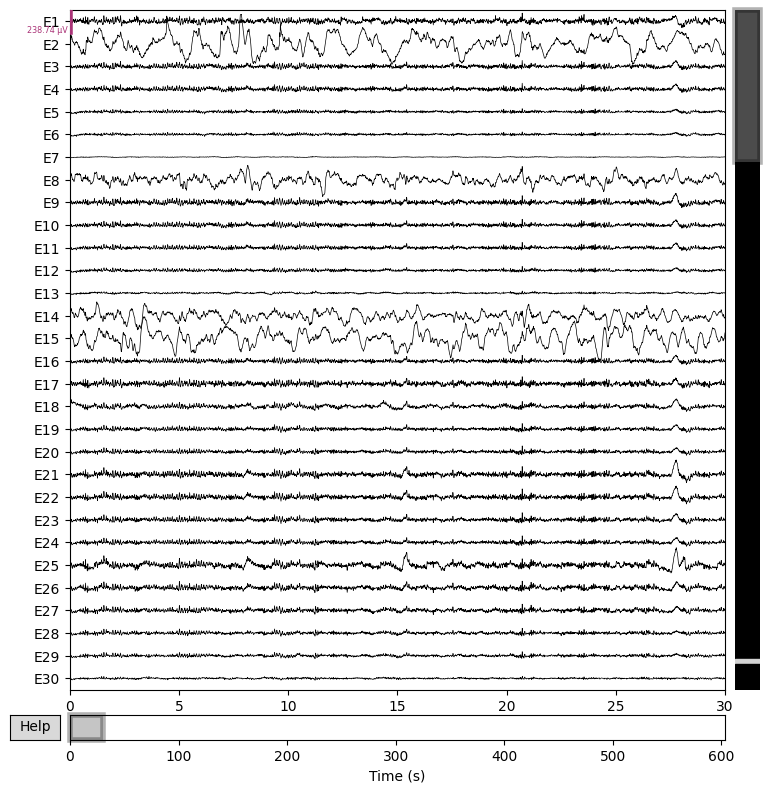

In [7]:
# Apply a band-pass filter
raw.filter(1, 40, fir_design="firwin")

# Plot the raw data
raw.plot(n_channels=30, duration=30, scalings="auto")
plt.close()

# Artifact removal using ICA

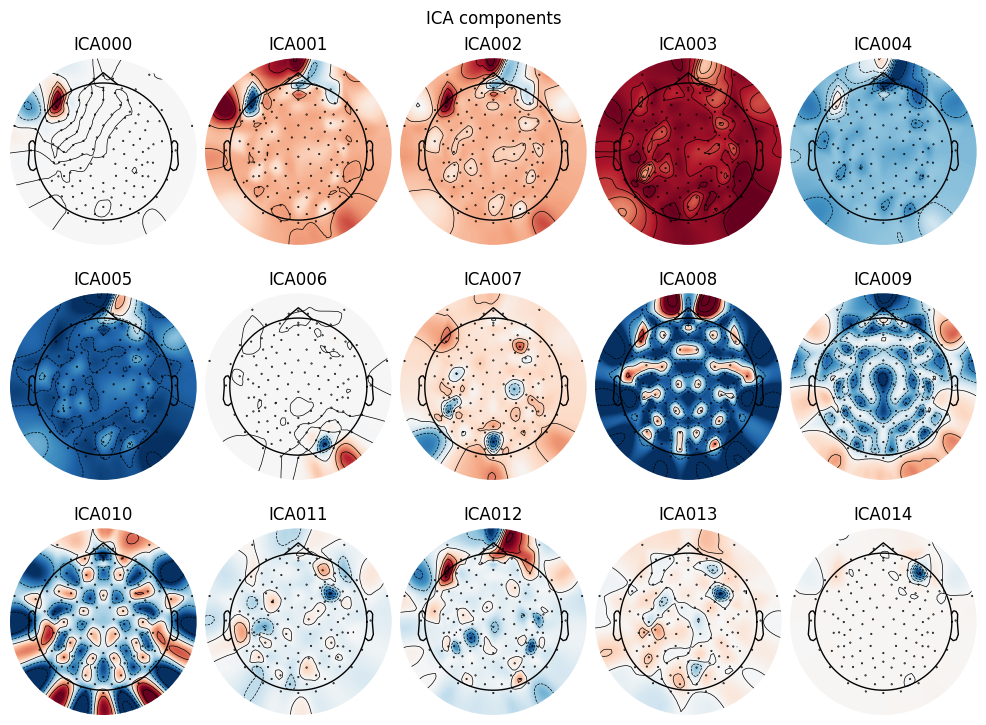

In [8]:
# Setup ICA
ica = mne.preprocessing.ICA(n_components=15, random_state=97)
ica.fit(raw)

# Plot ICA components
ica.plot_components()

# Select bad components manually (usually by visual inspection)
ica.exclude = [0, 6, 14]  # Example: components 0 and 1 are eye blinks and heartbeats

# Apply ICA removal
raw_clean = ica.apply(raw.copy())

# Power Spectral Analysis

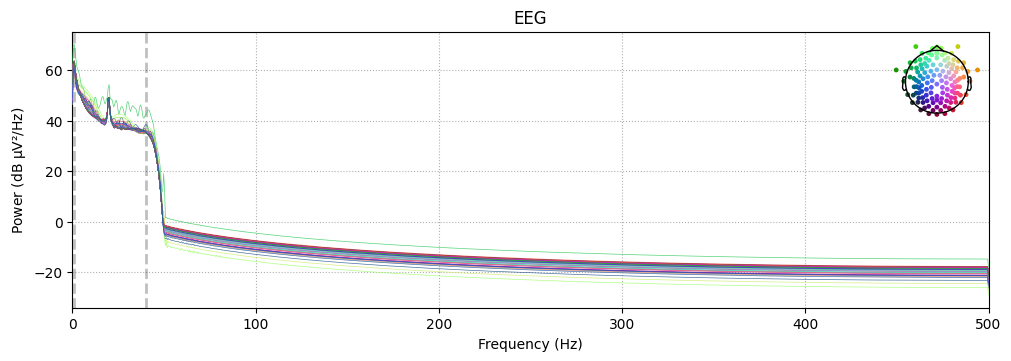

In [9]:
# Compute and plot Power Spectral Density (PSD)
raw_clean.compute_psd().plot(exclude="bads", amplitude=False)
plt.show()

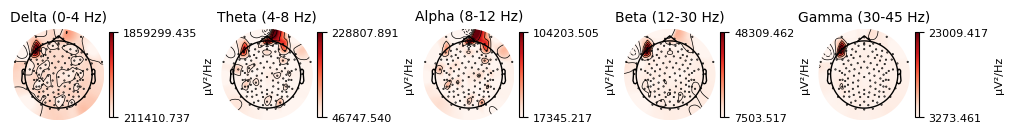

In [10]:
raw_clean.compute_psd().plot_topomap(ch_type="eeg", agg_fun=np.median)
plt.close()